# Hard Attention MNIST

This is jupyter notebook for `Hard Attention` from paper [Show, Attend and Tell](https://arxiv.org/abs/1502.03044). 
<br>This Algorithm will be tested by `Modified MNIST dataset` Which is made by [Jongwon Park](https://github.com/jwpark116). <br>This modified MNIST dataset is good for verifying attention algorithm.
<br>You can download modified MNIST data from this link
<br>[Training dataset](https://www.dropbox.com/s/e7jxyulxx2anqyq/MNIST_data_train_re.mat?dl=0)  /  [Testing dataset](https://www.dropbox.com/s/fcw4754bavva9my/MNIST_data_test_re.mat?dl=0)

# TENSORFLOW 1

In [1]:
# Import modules
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import random
import skimage.transform
import cv2
import os

/home/jenazads/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jenazads/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jenazads/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jenazads/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.

In [2]:
print(tf.version.VERSION)

1.14.0


In [3]:
print(tf.test.is_gpu_available())

False


In [4]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
((train_x, train_y), (test_x, test_y)) = cifar10.load_data()

train_x = train_x.astype("float32") / 255.0
test_x = test_x.astype("float32") / 255.0

train_y = to_categorical(train_y, 10)
test_y = to_categorical(test_y, 10)

print(train_x[0].shape, train_y.shape)
# train_x = np.expand_dims(train_x, axis=3)
# test_x = np.expand_dims(test_x, axis=3)
# print(train_x.shape, train_y.shape)

print("Train data shape: " + str(train_x.shape))
print("Train label shape: " + str(train_y.shape))
print("Test data shape: " + str(test_x.shape))
print("Test label shape: " + str(test_y.shape))
print(np.max(test_x), np.min(test_x))

input_shape = train_x[0].shape
output_shape = train_y[0].shape[0]
print(input_shape, output_shape)

IMG_SIZE, CHANNELS = input_shape[0], input_shape[2]
print(IMG_SIZE, CHANNELS)

(32, 32, 3) (50000, 10)
Train data shape: (50000, 32, 32, 3)
Train label shape: (50000, 10)
Test data shape: (10000, 32, 32, 3)
Test label shape: (10000, 10)
1.0 0.0
(32, 32, 3) 10
32 3


## Parameters

In [5]:
# Parameters 
img_size = train_x.shape[1]
img_flat_size = img_size * img_size

# If you want to train the model -> True, otherwise -> False
Is_train = True

# If you want to load saved model -> True, otherwise -> False 
Load_model = False

# Name of the save file
save_path = 'saved_models/cifrar_hard/'
if not os.path.exists(save_path):
  os.makedirs(save_path)

# Numbers of sampling to test the code 
num_test_sample = 50

# labels: 0 - 9
num_label = 10

# Parameters for training
num_epoch = 10

learning_rate = 5e-4
epsilon = 1e-8

batch_size = 256

# Parameter for LSTM
lstm_size = 256
step_size = 4
flatten_size = img_size

gpu_fraction = 0.3

## Plotting Sample Image (Modified MNIST for Attention)

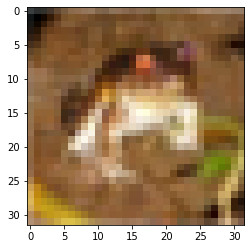

Label: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Shape: 32x32


In [6]:
# Plotting example image
img = train_x[0, :, :]

plt.imshow(img, cmap = 'gray')
plt.show()
print('Label: ' + str(train_y[0,:]))
print('Shape: ' + str(img_size) + 'x' + str(img_size))

## Functions for Convolutional Network

In [7]:
# Initialize weights and bias 
def conv2d(x,w, stride):
	return tf.nn.conv2d(x,w,strides=[1, stride, stride, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

# Get Variables
def weight_variable(name, shape):
    return tf.get_variable(name,shape=shape, initializer=tf.contrib.layers.xavier_initializer())

def bias_variable(name, shape):
    return tf.get_variable(name,shape=shape, initializer=tf.contrib.layers.xavier_initializer())

## LSTM and Attention function

In [8]:
# Reset the graph
tf.reset_default_graph()

# LSTM function
def LSTM_cell(C_prev, h_prev, x_lstm, Wf, Wi, Wc, Wo, bf, bi, bc, bo):
    # C_prev: Cell state from lstm of previous time step (shape: [batch_size, lstm_size])
    # h_prev: output from lstm of previous time step (shape: [batch_size, lstm_size])
    # x_lstm: input of lstm (shape: [batch_size, data_flatten_size])

    input_concat = tf.concat([x_lstm, h_prev], 1)
    f = tf.sigmoid(tf.matmul(input_concat, Wf) + bf)
    i = tf.sigmoid(tf.matmul(input_concat, Wi) + bi)
    c = tf.tanh(tf.matmul(input_concat, Wc) + bc)
    o = tf.sigmoid(tf.matmul(input_concat, Wo) + bo)
    
    C_t = tf.multiply(f, C_prev) + tf.multiply(i, c) 
    h_t = tf.multiply(o, tf.tanh(C_t))
    
    return C_t, h_t # Cell state, Output

# Hard Attention function
def hard_attention(h_prev, a, Wa, Wh):
    # h_prev: output from lstm of previous time step (shape: [batch_size, lstm_size])
    # a: Result of CNN [batch_size, conv_size * conv_size, channel_size] 

    m_list = [tf.tanh(tf.matmul(a[i], Wa) + tf.matmul(h_prev, Wh)) for i in range(len(a))] 
    m_concat = tf.concat([m_list[i] for i in range(len(a))], axis = 1)     
    alpha = tf.nn.softmax(m_concat) 
    
    #For Monte-Carlo Sampling
    alpha_cumsum = tf.cumsum(alpha, axis = 1)
    len_batch = tf.shape(alpha_cumsum)[0]
    rand_prob = tf.random_uniform(shape = [len_batch, 1], minval = 0., maxval = 1.)
    alpha_relu = tf.nn.relu(rand_prob - alpha_cumsum)
    alpha_index = tf.count_nonzero(alpha_relu, 1)
    alpha_hard  = tf.one_hot(alpha_index, len(a))

    z_list = [tf.multiply(a[i], tf.slice(alpha_hard, (0, i), (-1, 1))) for i in range(len(a))]
    z_stack = tf.stack(z_list, axis = 2)
    z = tf.reduce_sum(z_stack, axis = 2)

    return alpha, z
    

## Network

In [9]:
# Network

# Input 
x_image  = tf.placeholder(tf.float32, shape = [None, img_size, img_size, CHANNELS])
y_target = tf.placeholder(tf.float32, shape=[None, num_label])

# Convolution variables
w_conv1 = weight_variable('W_conv1', [3, 3, CHANNELS, 64])
b_conv1 = bias_variable('b_conv1', [64])
w_conv2 = weight_variable('W_conv2', [3, 3, 64, 256])
b_conv2 = bias_variable('b_conv2', [256])
w_conv3 = weight_variable('W_conv3', [3, 3, 256, 512])
b_conv3 = bias_variable('b_conv3', [512])

conv1 = tf.nn.relu(conv2d(x_image, w_conv1, 2) + b_conv1)
conv2 = tf.nn.relu(conv2d(conv1, w_conv2, 2) + b_conv2)
conv3 = tf.nn.relu(conv2d(conv2, w_conv3, 2) + b_conv3)

conv_size = conv3.get_shape()[1]
conv_flat = tf.reshape(conv3, [-1, conv_size*conv_size, 512])
conv_unstack = tf.unstack(conv_flat, axis = 1)

#LSTM Variables
Wf = weight_variable('Wf', [512 + lstm_size, lstm_size])
Wi = weight_variable('Wi', [512 + lstm_size, lstm_size])
Wc = weight_variable('Wc', [512 + lstm_size, lstm_size])
Wo = weight_variable('Wo', [512 + lstm_size, lstm_size])

bf = bias_variable('bf', [lstm_size])
bi = bias_variable('bi', [lstm_size])
bc = bias_variable('bc', [lstm_size])
bo = bias_variable('bo', [lstm_size]) 

# Attention Variables
Wa = weight_variable('Wa', [512, 1])
Wh = weight_variable('Wh', [lstm_size, 1])

rnn_batch_size = tf.shape(x_image)[0]

# Initial lstm cell state and output 
rnn_state = tf.zeros([rnn_batch_size, lstm_size], tf.float32)
rnn_out = tf.zeros([rnn_batch_size, lstm_size], tf.float32)

#################################### Attention!!! ####################################
for i in range(step_size):
    alpha, z = hard_attention(rnn_out, conv_unstack, Wa, Wh)
    rnn_state, rnn_out = LSTM_cell(rnn_state, rnn_out, z, Wf, Wi, Wc, Wo, bf, bi, bc, bo)

######################################################################################

# Densely connect layer variables 
w_fc1 = weight_variable('w_fc1', [lstm_size, num_label])
b_fc1 = bias_variable('b_fc1', [num_label])

output = tf.matmul(rnn_out, w_fc1)+b_fc1


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
reduction_indices is deprecated, use axis instead


In [10]:
# Training 
Loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = y_target, logits = output)
Cost = tf.reduce_mean(Loss)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate, epsilon = epsilon).minimize(Cost)

correct_prediction = tf.equal(tf.argmax(y_target,1), tf.argmax(output,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Create Session

In [11]:
# Create Session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = gpu_fraction

sess = tf.InteractiveSession(config=config)
sess.run(tf.global_variables_initializer())

## Save and Restore

In [12]:
# Load the file if the saved file exists
saver = tf.train.Saver()
if Load_model == True:
    checkpoint = tf.train.get_checkpoint_state(save_path)
    if checkpoint and checkpoint.model_checkpoint_path:
        saver.restore(sess, checkpoint.model_checkpoint_path)
        print("Successfully loaded:", checkpoint.model_checkpoint_path)
    else:
        print("Could not find old network weights")

## Training

In [14]:
# Training
interval_test=num_epoch/2
if Is_train == True:
    train_data_num = train_x.shape[0]
    test_data_num = test_x.shape[0]
    for i in range(num_epoch):
        # Making batches
        random_idx = np.arange(train_data_num)
        np.random.shuffle(random_idx)

        batch_count = 1
    
        for j in range(0, train_data_num, batch_size):
            if j + batch_size < train_data_num:
                batch_index = [j, j + batch_size]

                batch_x_train = train_x[random_idx[batch_index[0]:batch_index[1]],:,:]
                batch_y_train = train_y[random_idx[batch_index[0]:batch_index[1]],:]
            else:
                batch_index = [j, j + train_data_num-1]

                batch_x_train = train_x[random_idx[batch_index[0]:batch_index[-1]],:,:]
                batch_y_train = train_y[random_idx[batch_index[0]:batch_index[-1]],:]

            # Make image as fractions for attention
            train_batch = np.reshape(batch_x_train, (batch_x_train.shape[0], img_size, img_size, CHANNELS))
#             validation_batch = np.reshape(validation_x, (validation_x.shape[0], img_size, img_size, 1))
            
            # Training
            optimizer.run(feed_dict = {x_image: train_batch, y_target: batch_y_train})
            cost = sess.run(Cost, feed_dict = {x_image: train_batch, y_target: batch_y_train})
            acc = sess.run(accuracy, feed_dict = {x_image: train_batch, y_target: batch_y_train})
           # val_acc = sess.run(accuracy, feed_dict = {x_image: validation_batch, y_target: validation_y})

            # Print Progress
            print("Epoch: " + str(i+1) + ' / ' + 
                  "Batch: " + str(j) + '/' + str(train_data_num) + ' / ' + 
                  "Cost: " + str(cost) + ' / ' + 
                  "Training Accuracy: " + str(acc))# + ' / ' + 
#                   "Validation Accuracy: " + str(val_acc))  

        if (i+1)%interval_test==0:
            num_correct = 0
            saver.save(sess, save_path + "hard_attention")
            print('Model is saved!!!')

            print('Testing ...')
            idx = random.sample(range(test_x.shape[0]), test_data_num)
            for idx_sample in range(test_data_num):
                test_x_reshape = np.reshape(test_x, ([test_x.shape[0],img_size,img_size,CHANNELS]))
                test_x_in = test_x_reshape[idx[idx_sample],:,:,:]
                output_ = sess.run(output,feed_dict = {x_image: [test_x_in], y_target: [test_y[idx[idx_sample],:]]})
                
                y_test_pred = np.argmax(output_[:])
                y_test_true = np.argmax(test_y[idx[idx_sample], :])
                if y_test_pred == y_test_true:
                    num_correct += 1.
                
            # Print Progress
            print("Testing Accuracy: " + str(num_correct/test_data_num))# + ' / ' + )

Epoch: 1 / Batch: 0/50000 / Cost: 0.63777685 / Training Accuracy: 0.1015625
Epoch: 1 / Batch: 256/50000 / Cost: 0.5812942 / Training Accuracy: 0.1015625
Epoch: 1 / Batch: 512/50000 / Cost: 0.5092063 / Training Accuracy: 0.10546875
Epoch: 1 / Batch: 768/50000 / Cost: 0.42705566 / Training Accuracy: 0.11328125
Epoch: 1 / Batch: 1024/50000 / Cost: 0.36101562 / Training Accuracy: 0.08984375
Epoch: 1 / Batch: 1280/50000 / Cost: 0.33485794 / Training Accuracy: 0.09375
Epoch: 1 / Batch: 1536/50000 / Cost: 0.33701137 / Training Accuracy: 0.1015625
Epoch: 1 / Batch: 1792/50000 / Cost: 0.34872594 / Training Accuracy: 0.1015625
Epoch: 1 / Batch: 2048/50000 / Cost: 0.35207182 / Training Accuracy: 0.09375
Epoch: 1 / Batch: 2304/50000 / Cost: 0.3487394 / Training Accuracy: 0.078125
Epoch: 1 / Batch: 2560/50000 / Cost: 0.3393458 / Training Accuracy: 0.08984375
Epoch: 1 / Batch: 2816/50000 / Cost: 0.33267894 / Training Accuracy: 0.109375
Epoch: 1 / Batch: 3072/50000 / Cost: 0.32523373 / Training Accur

Epoch: 1 / Batch: 26624/50000 / Cost: 0.30289587 / Training Accuracy: 0.22265625
Epoch: 1 / Batch: 26880/50000 / Cost: 0.30822158 / Training Accuracy: 0.19921875
Epoch: 1 / Batch: 27136/50000 / Cost: 0.30306327 / Training Accuracy: 0.20703125
Epoch: 1 / Batch: 27392/50000 / Cost: 0.30833477 / Training Accuracy: 0.1484375
Epoch: 1 / Batch: 27648/50000 / Cost: 0.30044854 / Training Accuracy: 0.2109375
Epoch: 1 / Batch: 27904/50000 / Cost: 0.30266288 / Training Accuracy: 0.17578125
Epoch: 1 / Batch: 28160/50000 / Cost: 0.30217236 / Training Accuracy: 0.20703125
Epoch: 1 / Batch: 28416/50000 / Cost: 0.3092187 / Training Accuracy: 0.1953125
Epoch: 1 / Batch: 28672/50000 / Cost: 0.2964031 / Training Accuracy: 0.23828125
Epoch: 1 / Batch: 28928/50000 / Cost: 0.3035521 / Training Accuracy: 0.23828125
Epoch: 1 / Batch: 29184/50000 / Cost: 0.30028665 / Training Accuracy: 0.203125
Epoch: 1 / Batch: 29440/50000 / Cost: 0.3073873 / Training Accuracy: 0.1640625
Epoch: 1 / Batch: 29696/50000 / Cost: 

Epoch: 2 / Batch: 2816/50000 / Cost: 0.28776407 / Training Accuracy: 0.23828125
Epoch: 2 / Batch: 3072/50000 / Cost: 0.29228193 / Training Accuracy: 0.26953125
Epoch: 2 / Batch: 3328/50000 / Cost: 0.29444322 / Training Accuracy: 0.234375
Epoch: 2 / Batch: 3584/50000 / Cost: 0.29418325 / Training Accuracy: 0.234375
Epoch: 2 / Batch: 3840/50000 / Cost: 0.2979672 / Training Accuracy: 0.22265625
Epoch: 2 / Batch: 4096/50000 / Cost: 0.2941959 / Training Accuracy: 0.21484375
Epoch: 2 / Batch: 4352/50000 / Cost: 0.29716116 / Training Accuracy: 0.25
Epoch: 2 / Batch: 4608/50000 / Cost: 0.28645316 / Training Accuracy: 0.23828125
Epoch: 2 / Batch: 4864/50000 / Cost: 0.2989225 / Training Accuracy: 0.23046875
Epoch: 2 / Batch: 5120/50000 / Cost: 0.29333562 / Training Accuracy: 0.25
Epoch: 2 / Batch: 5376/50000 / Cost: 0.28474626 / Training Accuracy: 0.296875
Epoch: 2 / Batch: 5632/50000 / Cost: 0.29301304 / Training Accuracy: 0.2109375
Epoch: 2 / Batch: 5888/50000 / Cost: 0.2918269 / Training Accu

Epoch: 2 / Batch: 29184/50000 / Cost: 0.28237844 / Training Accuracy: 0.33984375
Epoch: 2 / Batch: 29440/50000 / Cost: 0.28558254 / Training Accuracy: 0.31640625
Epoch: 2 / Batch: 29696/50000 / Cost: 0.2865665 / Training Accuracy: 0.2734375
Epoch: 2 / Batch: 29952/50000 / Cost: 0.28622454 / Training Accuracy: 0.265625
Epoch: 2 / Batch: 30208/50000 / Cost: 0.28442425 / Training Accuracy: 0.28515625
Epoch: 2 / Batch: 30464/50000 / Cost: 0.29189685 / Training Accuracy: 0.23046875
Epoch: 2 / Batch: 30720/50000 / Cost: 0.28291544 / Training Accuracy: 0.2734375
Epoch: 2 / Batch: 30976/50000 / Cost: 0.2964008 / Training Accuracy: 0.26171875
Epoch: 2 / Batch: 31232/50000 / Cost: 0.2840547 / Training Accuracy: 0.30859375
Epoch: 2 / Batch: 31488/50000 / Cost: 0.29839915 / Training Accuracy: 0.24609375
Epoch: 2 / Batch: 31744/50000 / Cost: 0.28966886 / Training Accuracy: 0.2578125
Epoch: 2 / Batch: 32000/50000 / Cost: 0.29204878 / Training Accuracy: 0.25390625
Epoch: 2 / Batch: 32256/50000 / Cost

Epoch: 3 / Batch: 5632/50000 / Cost: 0.27935782 / Training Accuracy: 0.27734375
Epoch: 3 / Batch: 5888/50000 / Cost: 0.28466746 / Training Accuracy: 0.296875
Epoch: 3 / Batch: 6144/50000 / Cost: 0.2746319 / Training Accuracy: 0.32421875
Epoch: 3 / Batch: 6400/50000 / Cost: 0.27930713 / Training Accuracy: 0.3046875
Epoch: 3 / Batch: 6656/50000 / Cost: 0.2792148 / Training Accuracy: 0.2734375
Epoch: 3 / Batch: 6912/50000 / Cost: 0.28809825 / Training Accuracy: 0.27734375
Epoch: 3 / Batch: 7168/50000 / Cost: 0.27913794 / Training Accuracy: 0.28515625
Epoch: 3 / Batch: 7424/50000 / Cost: 0.2670632 / Training Accuracy: 0.3203125
Epoch: 3 / Batch: 7680/50000 / Cost: 0.28723505 / Training Accuracy: 0.3046875
Epoch: 3 / Batch: 7936/50000 / Cost: 0.271947 / Training Accuracy: 0.30078125
Epoch: 3 / Batch: 8192/50000 / Cost: 0.27747098 / Training Accuracy: 0.27734375
Epoch: 3 / Batch: 8448/50000 / Cost: 0.28266507 / Training Accuracy: 0.3359375
Epoch: 3 / Batch: 8704/50000 / Cost: 0.27840656 / Tr

Epoch: 3 / Batch: 32256/50000 / Cost: 0.27639857 / Training Accuracy: 0.28515625
Epoch: 3 / Batch: 32512/50000 / Cost: 0.2681334 / Training Accuracy: 0.3359375
Epoch: 3 / Batch: 32768/50000 / Cost: 0.27651638 / Training Accuracy: 0.3125
Epoch: 3 / Batch: 33024/50000 / Cost: 0.2681034 / Training Accuracy: 0.35546875
Epoch: 3 / Batch: 33280/50000 / Cost: 0.27688646 / Training Accuracy: 0.30859375
Epoch: 3 / Batch: 33536/50000 / Cost: 0.27270666 / Training Accuracy: 0.33203125
Epoch: 3 / Batch: 33792/50000 / Cost: 0.26893622 / Training Accuracy: 0.28515625
Epoch: 3 / Batch: 34048/50000 / Cost: 0.27866074 / Training Accuracy: 0.33984375
Epoch: 3 / Batch: 34304/50000 / Cost: 0.27099884 / Training Accuracy: 0.3046875
Epoch: 3 / Batch: 34560/50000 / Cost: 0.26912603 / Training Accuracy: 0.3359375
Epoch: 3 / Batch: 34816/50000 / Cost: 0.26654387 / Training Accuracy: 0.359375
Epoch: 3 / Batch: 35072/50000 / Cost: 0.27504516 / Training Accuracy: 0.3359375
Epoch: 3 / Batch: 35328/50000 / Cost: 0.

Epoch: 4 / Batch: 8704/50000 / Cost: 0.2655626 / Training Accuracy: 0.3359375
Epoch: 4 / Batch: 8960/50000 / Cost: 0.26397255 / Training Accuracy: 0.375
Epoch: 4 / Batch: 9216/50000 / Cost: 0.26237592 / Training Accuracy: 0.3359375
Epoch: 4 / Batch: 9472/50000 / Cost: 0.27040583 / Training Accuracy: 0.34765625
Epoch: 4 / Batch: 9728/50000 / Cost: 0.26420376 / Training Accuracy: 0.35546875
Epoch: 4 / Batch: 9984/50000 / Cost: 0.27621862 / Training Accuracy: 0.28515625
Epoch: 4 / Batch: 10240/50000 / Cost: 0.26081362 / Training Accuracy: 0.3671875
Epoch: 4 / Batch: 10496/50000 / Cost: 0.26390734 / Training Accuracy: 0.33984375
Epoch: 4 / Batch: 10752/50000 / Cost: 0.2741036 / Training Accuracy: 0.375
Epoch: 4 / Batch: 11008/50000 / Cost: 0.27168316 / Training Accuracy: 0.31640625
Epoch: 4 / Batch: 11264/50000 / Cost: 0.2717393 / Training Accuracy: 0.31640625
Epoch: 4 / Batch: 11520/50000 / Cost: 0.27066284 / Training Accuracy: 0.3125
Epoch: 4 / Batch: 11776/50000 / Cost: 0.26136118 / Tra

Epoch: 4 / Batch: 35072/50000 / Cost: 0.25698668 / Training Accuracy: 0.37890625
Epoch: 4 / Batch: 35328/50000 / Cost: 0.26534256 / Training Accuracy: 0.33984375
Epoch: 4 / Batch: 35584/50000 / Cost: 0.27122968 / Training Accuracy: 0.328125
Epoch: 4 / Batch: 35840/50000 / Cost: 0.2685924 / Training Accuracy: 0.37890625
Epoch: 4 / Batch: 36096/50000 / Cost: 0.26281095 / Training Accuracy: 0.34375
Epoch: 4 / Batch: 36352/50000 / Cost: 0.26676354 / Training Accuracy: 0.3359375
Epoch: 4 / Batch: 36608/50000 / Cost: 0.25638384 / Training Accuracy: 0.36328125
Epoch: 4 / Batch: 36864/50000 / Cost: 0.26110473 / Training Accuracy: 0.3984375
Epoch: 4 / Batch: 37120/50000 / Cost: 0.25992164 / Training Accuracy: 0.3203125
Epoch: 4 / Batch: 37376/50000 / Cost: 0.26719624 / Training Accuracy: 0.37109375
Epoch: 4 / Batch: 37632/50000 / Cost: 0.256637 / Training Accuracy: 0.375
Epoch: 4 / Batch: 37888/50000 / Cost: 0.26349404 / Training Accuracy: 0.3046875
Epoch: 4 / Batch: 38144/50000 / Cost: 0.26831

Epoch: 5 / Batch: 11520/50000 / Cost: 0.2589112 / Training Accuracy: 0.35546875
Epoch: 5 / Batch: 11776/50000 / Cost: 0.258109 / Training Accuracy: 0.33203125
Epoch: 5 / Batch: 12032/50000 / Cost: 0.26623794 / Training Accuracy: 0.31640625
Epoch: 5 / Batch: 12288/50000 / Cost: 0.26013526 / Training Accuracy: 0.3515625
Epoch: 5 / Batch: 12544/50000 / Cost: 0.25484237 / Training Accuracy: 0.3515625
Epoch: 5 / Batch: 12800/50000 / Cost: 0.25874472 / Training Accuracy: 0.34375
Epoch: 5 / Batch: 13056/50000 / Cost: 0.25952375 / Training Accuracy: 0.40625
Epoch: 5 / Batch: 13312/50000 / Cost: 0.26315242 / Training Accuracy: 0.34375
Epoch: 5 / Batch: 13568/50000 / Cost: 0.272501 / Training Accuracy: 0.3125
Epoch: 5 / Batch: 13824/50000 / Cost: 0.25843367 / Training Accuracy: 0.421875
Epoch: 5 / Batch: 14080/50000 / Cost: 0.25194106 / Training Accuracy: 0.41796875
Epoch: 5 / Batch: 14336/50000 / Cost: 0.26496497 / Training Accuracy: 0.33984375
Epoch: 5 / Batch: 14592/50000 / Cost: 0.26306322 /

Epoch: 5 / Batch: 38144/50000 / Cost: 0.25010842 / Training Accuracy: 0.359375
Epoch: 5 / Batch: 38400/50000 / Cost: 0.25199503 / Training Accuracy: 0.359375
Epoch: 5 / Batch: 38656/50000 / Cost: 0.25134426 / Training Accuracy: 0.4140625
Epoch: 5 / Batch: 38912/50000 / Cost: 0.2562722 / Training Accuracy: 0.40625
Epoch: 5 / Batch: 39168/50000 / Cost: 0.26063818 / Training Accuracy: 0.359375
Epoch: 5 / Batch: 39424/50000 / Cost: 0.26024073 / Training Accuracy: 0.359375
Epoch: 5 / Batch: 39680/50000 / Cost: 0.25550258 / Training Accuracy: 0.390625
Epoch: 5 / Batch: 39936/50000 / Cost: 0.26378155 / Training Accuracy: 0.37890625
Epoch: 5 / Batch: 40192/50000 / Cost: 0.25849083 / Training Accuracy: 0.36328125
Epoch: 5 / Batch: 40448/50000 / Cost: 0.24581675 / Training Accuracy: 0.40234375
Epoch: 5 / Batch: 40704/50000 / Cost: 0.24830091 / Training Accuracy: 0.359375
Epoch: 5 / Batch: 40960/50000 / Cost: 0.26397696 / Training Accuracy: 0.36328125
Epoch: 5 / Batch: 41216/50000 / Cost: 0.24702

Epoch: 6 / Batch: 14336/50000 / Cost: 0.25332814 / Training Accuracy: 0.39453125
Epoch: 6 / Batch: 14592/50000 / Cost: 0.25393924 / Training Accuracy: 0.3984375
Epoch: 6 / Batch: 14848/50000 / Cost: 0.2625234 / Training Accuracy: 0.421875
Epoch: 6 / Batch: 15104/50000 / Cost: 0.25147995 / Training Accuracy: 0.390625
Epoch: 6 / Batch: 15360/50000 / Cost: 0.2570049 / Training Accuracy: 0.37109375
Epoch: 6 / Batch: 15616/50000 / Cost: 0.26302987 / Training Accuracy: 0.3828125
Epoch: 6 / Batch: 15872/50000 / Cost: 0.24767494 / Training Accuracy: 0.37109375
Epoch: 6 / Batch: 16128/50000 / Cost: 0.24928145 / Training Accuracy: 0.359375
Epoch: 6 / Batch: 16384/50000 / Cost: 0.26306668 / Training Accuracy: 0.3828125
Epoch: 6 / Batch: 16640/50000 / Cost: 0.24986896 / Training Accuracy: 0.37109375
Epoch: 6 / Batch: 16896/50000 / Cost: 0.24595597 / Training Accuracy: 0.41015625
Epoch: 6 / Batch: 17152/50000 / Cost: 0.25358522 / Training Accuracy: 0.32421875
Epoch: 6 / Batch: 17408/50000 / Cost: 0

Epoch: 6 / Batch: 40704/50000 / Cost: 0.26133388 / Training Accuracy: 0.3671875
Epoch: 6 / Batch: 40960/50000 / Cost: 0.25055805 / Training Accuracy: 0.39453125
Epoch: 6 / Batch: 41216/50000 / Cost: 0.26813155 / Training Accuracy: 0.39453125
Epoch: 6 / Batch: 41472/50000 / Cost: 0.26029295 / Training Accuracy: 0.37109375
Epoch: 6 / Batch: 41728/50000 / Cost: 0.24616995 / Training Accuracy: 0.3671875
Epoch: 6 / Batch: 41984/50000 / Cost: 0.24713302 / Training Accuracy: 0.3671875
Epoch: 6 / Batch: 42240/50000 / Cost: 0.24499497 / Training Accuracy: 0.36328125
Epoch: 6 / Batch: 42496/50000 / Cost: 0.24532357 / Training Accuracy: 0.390625
Epoch: 6 / Batch: 42752/50000 / Cost: 0.24714625 / Training Accuracy: 0.40625
Epoch: 6 / Batch: 43008/50000 / Cost: 0.25402892 / Training Accuracy: 0.3984375
Epoch: 6 / Batch: 43264/50000 / Cost: 0.26133996 / Training Accuracy: 0.421875
Epoch: 6 / Batch: 43520/50000 / Cost: 0.24994811 / Training Accuracy: 0.39453125
Epoch: 6 / Batch: 43776/50000 / Cost: 0

Epoch: 7 / Batch: 17152/50000 / Cost: 0.25055876 / Training Accuracy: 0.38671875
Epoch: 7 / Batch: 17408/50000 / Cost: 0.23546013 / Training Accuracy: 0.41015625
Epoch: 7 / Batch: 17664/50000 / Cost: 0.24166003 / Training Accuracy: 0.41796875
Epoch: 7 / Batch: 17920/50000 / Cost: 0.2488952 / Training Accuracy: 0.44140625
Epoch: 7 / Batch: 18176/50000 / Cost: 0.25240868 / Training Accuracy: 0.37890625
Epoch: 7 / Batch: 18432/50000 / Cost: 0.25723243 / Training Accuracy: 0.359375
Epoch: 7 / Batch: 18688/50000 / Cost: 0.24161048 / Training Accuracy: 0.41796875
Epoch: 7 / Batch: 18944/50000 / Cost: 0.23748188 / Training Accuracy: 0.41796875
Epoch: 7 / Batch: 19200/50000 / Cost: 0.24717934 / Training Accuracy: 0.44921875
Epoch: 7 / Batch: 19456/50000 / Cost: 0.24565816 / Training Accuracy: 0.41796875
Epoch: 7 / Batch: 19712/50000 / Cost: 0.25173116 / Training Accuracy: 0.4140625
Epoch: 7 / Batch: 19968/50000 / Cost: 0.24224786 / Training Accuracy: 0.41015625
Epoch: 7 / Batch: 20224/50000 / 

Epoch: 7 / Batch: 43520/50000 / Cost: 0.23639636 / Training Accuracy: 0.375
Epoch: 7 / Batch: 43776/50000 / Cost: 0.2515158 / Training Accuracy: 0.3671875
Epoch: 7 / Batch: 44032/50000 / Cost: 0.2435298 / Training Accuracy: 0.4453125
Epoch: 7 / Batch: 44288/50000 / Cost: 0.23578921 / Training Accuracy: 0.453125
Epoch: 7 / Batch: 44544/50000 / Cost: 0.24550588 / Training Accuracy: 0.40625
Epoch: 7 / Batch: 44800/50000 / Cost: 0.2418973 / Training Accuracy: 0.47265625
Epoch: 7 / Batch: 45056/50000 / Cost: 0.23510143 / Training Accuracy: 0.453125
Epoch: 7 / Batch: 45312/50000 / Cost: 0.24433121 / Training Accuracy: 0.36328125
Epoch: 7 / Batch: 45568/50000 / Cost: 0.23573744 / Training Accuracy: 0.44140625
Epoch: 7 / Batch: 45824/50000 / Cost: 0.2388613 / Training Accuracy: 0.41796875
Epoch: 7 / Batch: 46080/50000 / Cost: 0.25629702 / Training Accuracy: 0.37890625
Epoch: 7 / Batch: 46336/50000 / Cost: 0.2405601 / Training Accuracy: 0.45703125
Epoch: 7 / Batch: 46592/50000 / Cost: 0.2292188

Epoch: 8 / Batch: 19712/50000 / Cost: 0.23555842 / Training Accuracy: 0.4296875
Epoch: 8 / Batch: 19968/50000 / Cost: 0.22841278 / Training Accuracy: 0.484375
Epoch: 8 / Batch: 20224/50000 / Cost: 0.24688399 / Training Accuracy: 0.43359375
Epoch: 8 / Batch: 20480/50000 / Cost: 0.24863152 / Training Accuracy: 0.40625
Epoch: 8 / Batch: 20736/50000 / Cost: 0.21898696 / Training Accuracy: 0.4609375
Epoch: 8 / Batch: 20992/50000 / Cost: 0.24139461 / Training Accuracy: 0.40234375
Epoch: 8 / Batch: 21248/50000 / Cost: 0.25304848 / Training Accuracy: 0.4453125
Epoch: 8 / Batch: 21504/50000 / Cost: 0.23124246 / Training Accuracy: 0.4609375
Epoch: 8 / Batch: 21760/50000 / Cost: 0.26215538 / Training Accuracy: 0.35546875
Epoch: 8 / Batch: 22016/50000 / Cost: 0.23913941 / Training Accuracy: 0.41796875
Epoch: 8 / Batch: 22272/50000 / Cost: 0.24817452 / Training Accuracy: 0.4140625
Epoch: 8 / Batch: 22528/50000 / Cost: 0.240025 / Training Accuracy: 0.43359375
Epoch: 8 / Batch: 22784/50000 / Cost: 0.

Epoch: 8 / Batch: 46080/50000 / Cost: 0.23265679 / Training Accuracy: 0.4453125
Epoch: 8 / Batch: 46336/50000 / Cost: 0.23917873 / Training Accuracy: 0.44921875
Epoch: 8 / Batch: 46592/50000 / Cost: 0.25372997 / Training Accuracy: 0.3671875
Epoch: 8 / Batch: 46848/50000 / Cost: 0.24357434 / Training Accuracy: 0.41796875
Epoch: 8 / Batch: 47104/50000 / Cost: 0.23168549 / Training Accuracy: 0.4296875
Epoch: 8 / Batch: 47360/50000 / Cost: 0.24836998 / Training Accuracy: 0.42578125
Epoch: 8 / Batch: 47616/50000 / Cost: 0.2587014 / Training Accuracy: 0.38671875
Epoch: 8 / Batch: 47872/50000 / Cost: 0.2539124 / Training Accuracy: 0.390625
Epoch: 8 / Batch: 48128/50000 / Cost: 0.24956512 / Training Accuracy: 0.3984375
Epoch: 8 / Batch: 48384/50000 / Cost: 0.24600244 / Training Accuracy: 0.375
Epoch: 8 / Batch: 48640/50000 / Cost: 0.26503104 / Training Accuracy: 0.4296875
Epoch: 8 / Batch: 48896/50000 / Cost: 0.24375975 / Training Accuracy: 0.453125
Epoch: 8 / Batch: 49152/50000 / Cost: 0.2556

Epoch: 9 / Batch: 22528/50000 / Cost: 0.23013727 / Training Accuracy: 0.44140625
Epoch: 9 / Batch: 22784/50000 / Cost: 0.23562062 / Training Accuracy: 0.453125
Epoch: 9 / Batch: 23040/50000 / Cost: 0.24724655 / Training Accuracy: 0.41015625
Epoch: 9 / Batch: 23296/50000 / Cost: 0.24780107 / Training Accuracy: 0.421875
Epoch: 9 / Batch: 23552/50000 / Cost: 0.25160137 / Training Accuracy: 0.3984375
Epoch: 9 / Batch: 23808/50000 / Cost: 0.23138587 / Training Accuracy: 0.46875
Epoch: 9 / Batch: 24064/50000 / Cost: 0.23980579 / Training Accuracy: 0.42578125
Epoch: 9 / Batch: 24320/50000 / Cost: 0.23782673 / Training Accuracy: 0.4140625
Epoch: 9 / Batch: 24576/50000 / Cost: 0.23772612 / Training Accuracy: 0.46875
Epoch: 9 / Batch: 24832/50000 / Cost: 0.22871701 / Training Accuracy: 0.48046875
Epoch: 9 / Batch: 25088/50000 / Cost: 0.24953647 / Training Accuracy: 0.3515625
Epoch: 9 / Batch: 25344/50000 / Cost: 0.24962202 / Training Accuracy: 0.41796875
Epoch: 9 / Batch: 25600/50000 / Cost: 0.2

Epoch: 9 / Batch: 48896/50000 / Cost: 0.24301763 / Training Accuracy: 0.421875
Epoch: 9 / Batch: 49152/50000 / Cost: 0.23427829 / Training Accuracy: 0.41796875
Epoch: 9 / Batch: 49408/50000 / Cost: 0.24061573 / Training Accuracy: 0.375
Epoch: 9 / Batch: 49664/50000 / Cost: 0.23708007 / Training Accuracy: 0.41796875
Epoch: 9 / Batch: 49920/50000 / Cost: 0.22521882 / Training Accuracy: 0.4875
Epoch: 10 / Batch: 0/50000 / Cost: 0.23265481 / Training Accuracy: 0.47265625
Epoch: 10 / Batch: 256/50000 / Cost: 0.23115432 / Training Accuracy: 0.43359375
Epoch: 10 / Batch: 512/50000 / Cost: 0.23923525 / Training Accuracy: 0.41015625
Epoch: 10 / Batch: 768/50000 / Cost: 0.24063706 / Training Accuracy: 0.375
Epoch: 10 / Batch: 1024/50000 / Cost: 0.24318917 / Training Accuracy: 0.421875
Epoch: 10 / Batch: 1280/50000 / Cost: 0.23017232 / Training Accuracy: 0.4453125
Epoch: 10 / Batch: 1536/50000 / Cost: 0.23725493 / Training Accuracy: 0.4453125
Epoch: 10 / Batch: 1792/50000 / Cost: 0.2385346 / Trai

Epoch: 10 / Batch: 25088/50000 / Cost: 0.2295558 / Training Accuracy: 0.44140625
Epoch: 10 / Batch: 25344/50000 / Cost: 0.23999004 / Training Accuracy: 0.44140625
Epoch: 10 / Batch: 25600/50000 / Cost: 0.24007156 / Training Accuracy: 0.40234375
Epoch: 10 / Batch: 25856/50000 / Cost: 0.23627059 / Training Accuracy: 0.48046875
Epoch: 10 / Batch: 26112/50000 / Cost: 0.2357204 / Training Accuracy: 0.453125
Epoch: 10 / Batch: 26368/50000 / Cost: 0.23313637 / Training Accuracy: 0.4765625
Epoch: 10 / Batch: 26624/50000 / Cost: 0.24597266 / Training Accuracy: 0.421875
Epoch: 10 / Batch: 26880/50000 / Cost: 0.23409161 / Training Accuracy: 0.4453125
Epoch: 10 / Batch: 27136/50000 / Cost: 0.22686963 / Training Accuracy: 0.41796875
Epoch: 10 / Batch: 27392/50000 / Cost: 0.22247985 / Training Accuracy: 0.46875
Epoch: 10 / Batch: 27648/50000 / Cost: 0.24553013 / Training Accuracy: 0.453125
Epoch: 10 / Batch: 27904/50000 / Cost: 0.24632736 / Training Accuracy: 0.4140625
Epoch: 10 / Batch: 28160/50000

## Testing

/home/jenazads/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


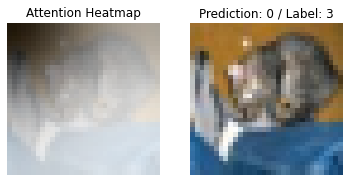

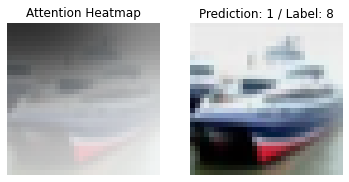

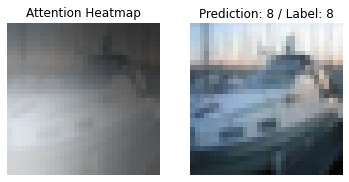

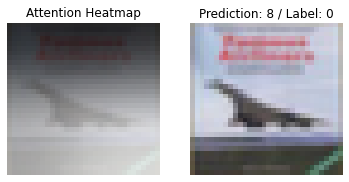

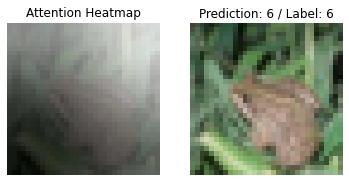

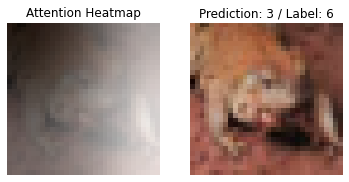

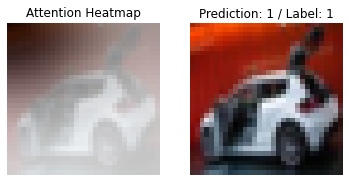

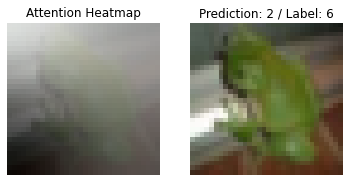

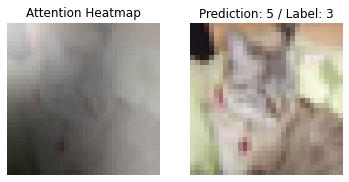

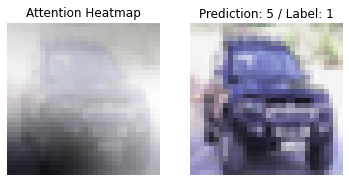

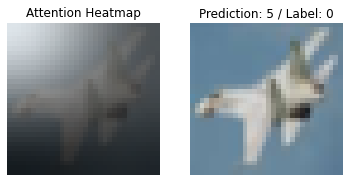

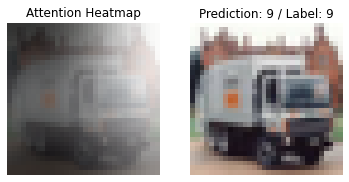

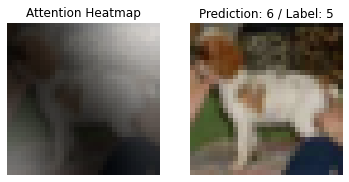

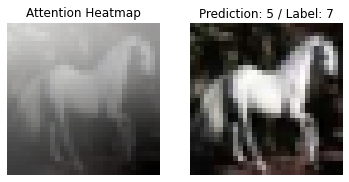

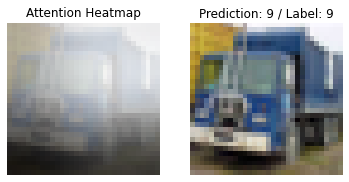

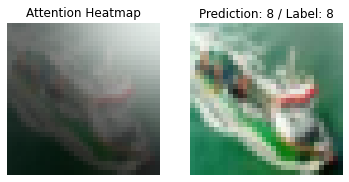

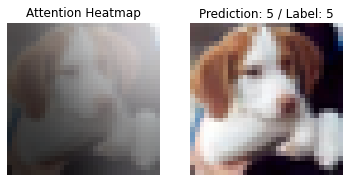

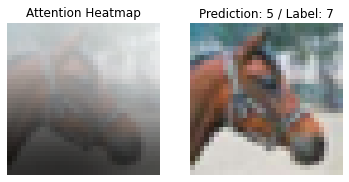

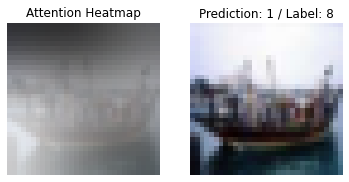

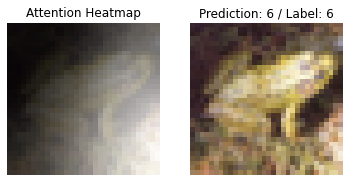

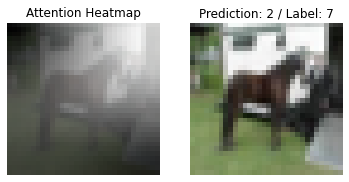

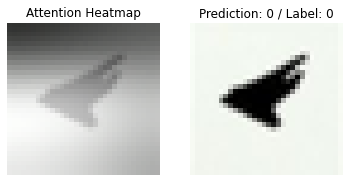

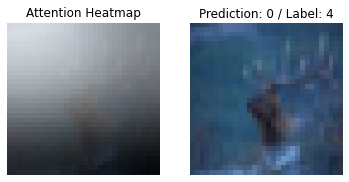

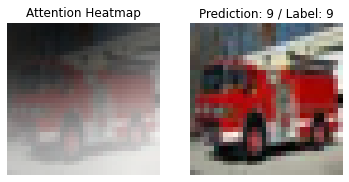

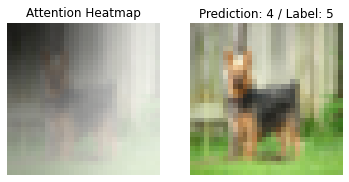

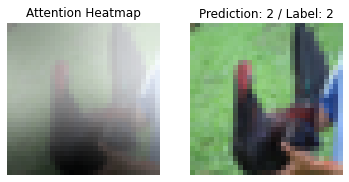

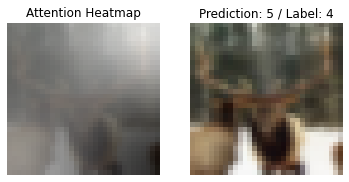

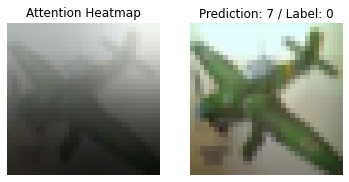

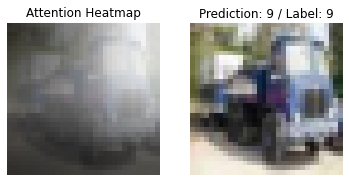

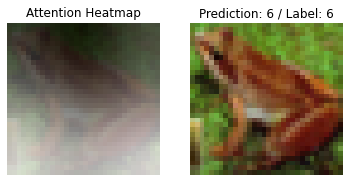

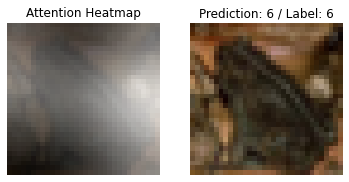

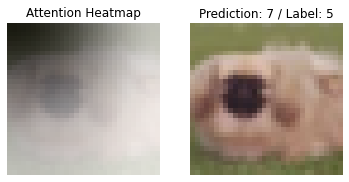

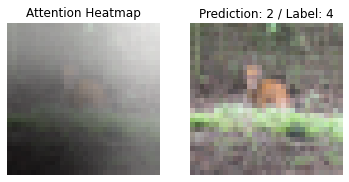

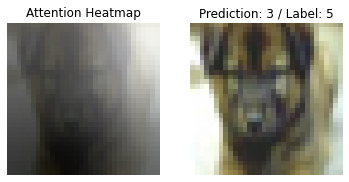

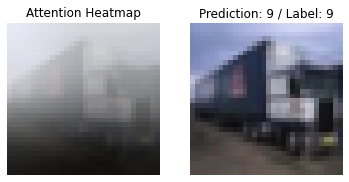

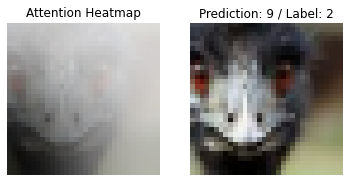

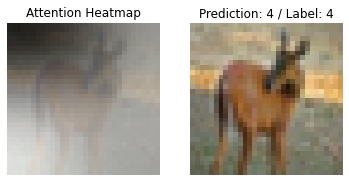

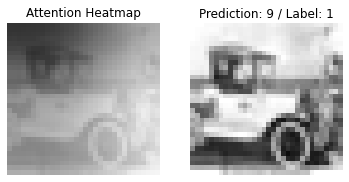

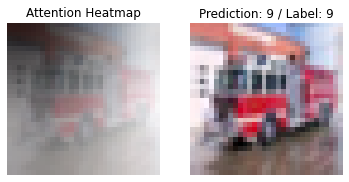

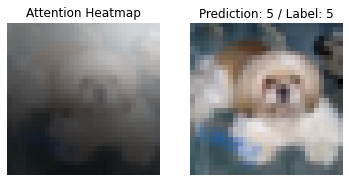

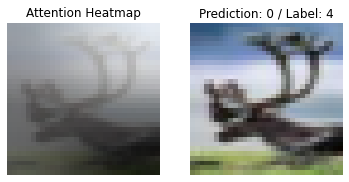

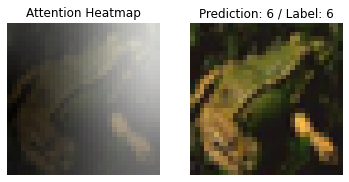

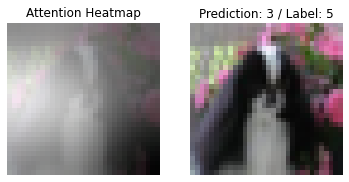

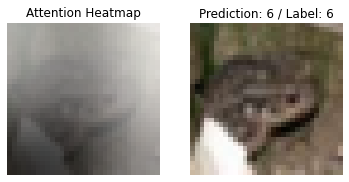

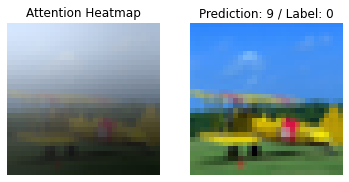

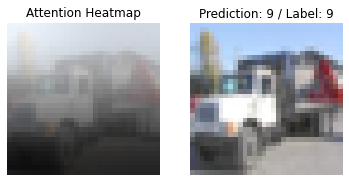

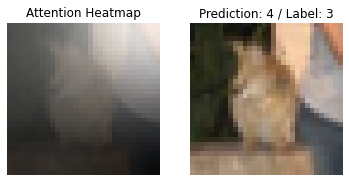

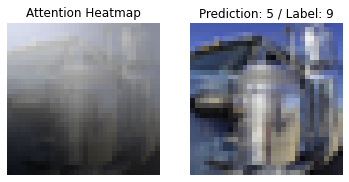

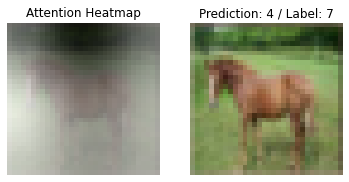

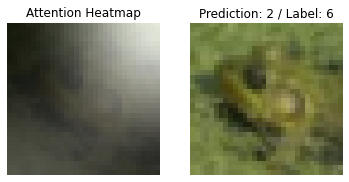

Sample Accuracy: 0.42


In [16]:
# Initialize fraction of test images and heatmap
test_fraction = np.zeros([10, img_size, img_size, 1])
heat_map = np.zeros([num_test_sample, img_size, img_size])

num_correct = 0.

# Test for Sampling data
for idx_sample in range(num_test_sample):
    
    # Get alpha(weight of fractions) and output for sample test data
    test_x_reshape = np.reshape(test_x, ([test_x.shape[0],img_size,img_size,CHANNELS]))
    test_x_in = test_x_reshape[idx_sample,:,:,:]
    alpha_, output_ = sess.run([alpha, output],feed_dict = {x_image: [test_x_in], y_target: [test_y[idx_sample,:]]})
    alpha_size = int(np.sqrt(alpha_.shape[1]))
    alpha_reshape = np.reshape(alpha_, (alpha_size, alpha_size))
    alpha_resize = skimage.transform.pyramid_expand(alpha_reshape, upscale = 16, sigma=20)
    alpha_resize = cv2.resize(alpha_resize, dsize=(img_size,img_size), interpolation=cv2.INTER_LINEAR)
    
    # Make heatmap with alpha

    # Get labels for test samples
    y_test_pred = np.argmax(output_[:])
    y_test_true = np.argmax(test_y[idx_sample, :])
    
    # Draw subplot for each sample 
    f1, ax = plt.subplots(1,2)
    ax[0].imshow(test_x[idx_sample,:,:], cmap='gray')
    i = ax[0].imshow(alpha_resize,cmap="gray", alpha=0.8)
    ax[0].axis("off")
    ax[0].set_title('Attention Heatmap')
    
    ax[1].imshow(test_x[idx_sample,:,:], cmap='gray')
    ax[1].axis("off")
    ax[1].set_title('Prediction: ' + str(y_test_pred) + ' / ' + 'Label: ' + str(y_test_true))

    # Count correct
    if y_test_pred == y_test_true:
        num_correct += 1.

# Show results 
plt.show()
print('Sample Accuracy: ' + str(num_correct / num_test_sample))